# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [106]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/olive/dev/lab1A
HopsworksSettings initialized!


In [107]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util

In [108]:
#today = datetime.datetime.now() - datetime.timedelta(0)
#tomorrow = today + datetime.timedelta(days = 1)
#today

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [109]:
def get_env(identifier):
    project = hopsworks.login()
    fs = project.get_feature_store() 
    
    secrets = hopsworks.get_secrets_api()
    location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{identifier.lower()}").value
    location = json.loads(location_str)
    country=location['country']
    city=location['city']
    street=location['street']

    return project, fs, country, city, street

## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [110]:
def get_model(project,street):
    mr = project.get_model_registry()
    
    retrieved_model = mr.get_model(
        name=f"air_quality_xgboost_model_v_agrade_{street.lower()}",
        version=1,
    )
    
    fv = retrieved_model.get_feature_view()
    
    
    # Download the saved model artifacts to a local directory
    saved_model_dir = retrieved_model.download()

    retrieved_xgboost_model = XGBRegressor()

    retrieved_xgboost_model.load_model(saved_model_dir + f"/model_{street.lower()}.json")
    
    # Displaying the retrieved XGBoost regressor model
    retrieved_xgboost_model

    return retrieved_xgboost_model, fv

In [111]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
#retrieved_xgboost_model = XGBRegressor()

#retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
#retrieved_xgboost_model

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [112]:
def get_forecast_stuff(fs,street,today):
    weather_fg = fs.get_feature_group(
        name=f"weather_v_agrade_{street.lower()}",
        version=1,
    )
    batch_data = weather_fg.filter(weather_fg.date >= today).read()
    batch_data

    return batch_data, weather_fg

In [113]:
# NEW. ADDS ROLLING MEAN FOR FIRST DAY AND 0 VALUE IN ALL COLUMN FOR ROLL
"""import pytz

adj_tomorrow = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)

air_quality_group = fs.get_feature_group(name='air_quality', version=1)
first_init_roll = air_quality_group.filter(air_quality_group.date >= adj_tomorrow -  datetime.timedelta(4)).read()
print(first_init_roll)
batch_data["roll"] = pd.Series(0, index=batch_data.index).astype("float64")
batch_data.loc[batch_data["date"] == adj_tomorrow, "roll"] = first_init_roll["pm25"].mean()
#batch_data"""
def add_rolling(fs,street,batch_data):
    import pytz
    
    adj_tomorrow = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    adj_2day = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=2)).replace(hour=0, minute=0, second=0, microsecond=0)
    adj_3day = (datetime.datetime.now(tz=pytz.UTC) + datetime.timedelta(days=3)).replace(hour=0, minute=0, second=0, microsecond=0)
    
    air_quality_group = fs.get_feature_group(name=f"air_quality_v_agrade_{street.lower()}", version=1)
    first_init_roll = air_quality_group.filter(air_quality_group.date >= adj_tomorrow -  datetime.timedelta(4)).read()
    #print(first_init_roll)
    pm_series = first_init_roll.sort_values('date')['pm25'].tail(3)
    
    rolling3 = pm_series.mean()
    lag1 = pm_series.iloc[-1]
    lag2 = pm_series.iloc[-2]
    lag3 = pm_series.iloc[-3]
    
    m1 = batch_data['date'] == adj_tomorrow
    m2 = batch_data['date'] == adj_2day
    m3 = batch_data['date'] == adj_3day
    
    batch_data.loc[m1, 'rolling3'] = rolling3
    batch_data.loc[m1, ['lag1d', 'lag2d', 'lag3d']] = [lag1, lag2, lag3]
    
    batch_data.loc[m2, ['lag2d', 'lag3d']] = [lag1, lag2]
    
    batch_data.loc[m3, ['lag3d']] = lag1
    
    batch_data

    return batch_data, adj_tomorrow, first_init_roll

### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [114]:
# OLD SOLUTION IGNORING ROLLING MEAN
#batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
#    batch_data[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
#batch_data

###########################
"""
old loop logic
predicted_pm = retrieved_xgboost_model.predict(
        batch_data.loc[batch_data["date"] == time_obj,
    ["roll", "temperature_2m_mean", "precipitation_sum", "wind_speed_10m_max", "wind_direction_10m_dominant"]])
    batch_data.loc[batch_data["date"] == time_obj, "predicted_pm25"] = predicted_pm
    
    first_init_roll.loc[len(first_init_roll)] = {"date":time_obj, "pm25":predicted_pm[0], "roll":0.0, "country":"Japan", "city":"saitama-ken", "street":"gakuendai", "url":"https://api.waqi.info/feed/@9937"}
    time_obj += datetime.timedelta(days=1)
    batch_data.loc[batch_data["date"] == time_obj, "roll"] = first_init_roll["pm25"].tail(3).mean()

"""
# NEW SOLUTION WITH ROLLING MEAN
def predictions(adj_tomorrow,batch_data,retrieved_xgboost_model,country,city,street,url,first_init_roll):
    time_obj = adj_tomorrow
    
    for _ in range(len(batch_data)):
    
        mask = batch_data["date"] == time_obj
        
        X = batch_data.loc[mask,["rolling3", "lag1d", "lag2d", "lag3d", 
                                 "temperature_2m_mean", "precipitation_sum", 
                                 "wind_speed_10m_max", "wind_direction_10m_dominant"]]
    
        y_pred = retrieved_xgboost_model.predict(X)[0]
        batch_data.loc[mask, "predicted_pm25"] = y_pred
    
        new_data = {
            "date": time_obj,
            "pm25": y_pred,
            "country": country,
            "city": city,
            "street": street,
            "url": url,
        }
    
        first_init_roll = pd.concat([first_init_roll, pd.DataFrame([new_data])], ignore_index=True)
    
        time_next = time_obj + datetime.timedelta(days=1)
    
        if(batch_data["date"]== time_next).any():
            recent = first_init_roll.sort_values("date")["pm25"].tail(3)
    
            rolling3 = recent.mean()
            lag1 = recent.iloc[-1]
            lag2 = recent.iloc[-2]
            lag3 = recent.iloc[-3]
    
            mask_next = batch_data["date"] == time_next
            batch_data.loc[mask_next, ["rolling3", "lag1d", "lag2d", "lag3d"]] = [rolling3,lag1,lag2,lag3]
    
        time_obj = time_next
        
            
    
    
    
    batch_data

    return batch_data

In [115]:
#batch_data.info()

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [116]:
def add_info_data(batch_data,street,city,country):
    batch_data['street'] = street
    batch_data['city'] = city
    batch_data['country'] = country
    # Fill in the number of days before the date on which you made the forecast (base_date)
    batch_data = batch_data.sort_values(by=['date'])
    batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
    batch_data

    return batch_data

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

In [117]:
#batch_data.info()

In [118]:
def create_forecast(street,city,batch_data):
    pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{street.lower()}.png"
    plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)
    
    plt.show()
    return pred_file_path

In [119]:
def create_monitor_fg(street,batch_data, fs):
    # Get or create feature group
    monitor_fg = fs.get_or_create_feature_group(
        name=f"aq_predictions_v_agrade_{street.lower()}",
        description='Air Quality prediction monitoring',
        version=1,
        primary_key=['city','street','date','days_before_forecast_day'],
        event_time="date"
    )
    monitor_fg.insert(batch_data, wait=True)

    return monitor_fg

In [120]:
#monitor_fg.insert(batch_data, wait=True)

In [121]:
def create_monitor_df(monitor_fg):
    # We will create a hindcast chart for  only the forecasts made 1 day beforehand
    monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
    monitoring_df

    return monitoring_df

In [122]:
def create_aq_df(fs,street):
    air_quality_fg = fs.get_feature_group(name=f"air_quality_v_agrade_{street.lower()}", version=1)
    air_quality_df = air_quality_fg.read()
    air_quality_df

    return air_quality_fg, air_quality_df

In [123]:
def hindcast(air_quality_df, monitoring_df):
    outcome_df = air_quality_df[['date', 'pm25']]
    preds_df =  monitoring_df[['date', 'predicted_pm25']]
    
    hindcast_df = pd.merge(preds_df, outcome_df, on="date")
    hindcast_df = hindcast_df.sort_values(by=['date'])
    print(len(hindcast_df))
    # If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
    if len(hindcast_df) == 0:
        pass
        #hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
        # we need to predict with our model since its C version
        
        """features_df = weather_fg.read()
        features_df = features_df.sort_values(by=['date'], ascending=True)
        features_df = features_df.tail(10)
    
        X = pd.concat([
        batch_data.sort_values(by=['date'], ascending=True)[["date","roll"]].reset_index(drop=True),
        features_df[['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']].reset_index(drop=True)
        ], axis=1)
        
        X['predicted_pm25'] = retrieved_xgboost_model.predict(X[["roll","temperature_2m_mean","precipitation_sum","wind_speed_10m_max","wind_direction_10m_dominant"]])
        df = pd.merge(X, air_quality_df[['date','pm25','street','country',"city"]], on="date")
        df['days_before_forecast_day'] = 1
        hindcast_df = df
        df = df.drop('pm25', axis=1)
        monitor_fg.insert(df, write_options={"wait_for_job": True})"""
        
    hindcast_df

    return hindcast_df

### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

In [124]:
def plot_hindcast(street,city,hindcast_df):
    hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{street.lower()}.png"
    plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
    plt.show()
    return hindcast_file_path

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [125]:
def upload_hops(project, today, city, street, pred_file_path, hindcast_file_path):
    dataset_api = project.get_dataset_api()
    str_today = today.strftime("%Y-%m-%d")
    if dataset_api.exists("Resources/airquality_v_agrade") == False:
        dataset_api.mkdir("Resources/airquality_v_agrade")
    dataset_api.upload(pred_file_path, f"Resources/airquality_v_agrade/{city}_{street}_{str_today}", overwrite=True)
    dataset_api.upload(hindcast_file_path, f"Resources/airquality_v_agrade/{city}_{street}_{str_today}", overwrite=True)
    
    proj_url = project.get_url()
    print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_v_agrade")

2025-11-15 16:08:26,899 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 16:08:26,901 INFO: Initializing external client
2025-11-15 16:08:26,902 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 16:08:27,462 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 16:08:30,268 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286329
2025-11-15 16:08:34,508 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/538100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/514472 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114640 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108903 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26639 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27075 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.77s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.54s) 


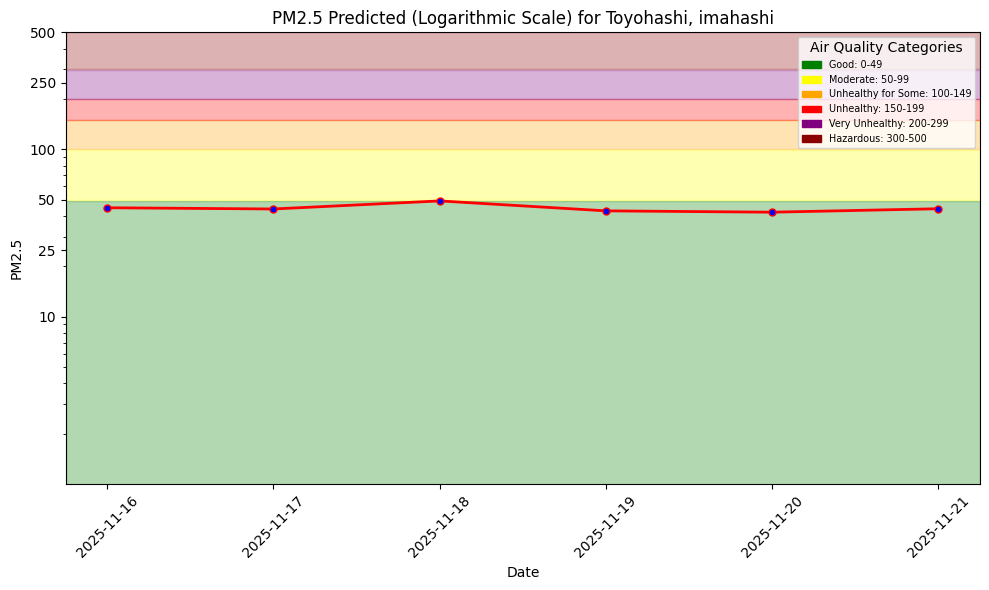

Uploading Dataframe: 100.00% |██████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_imahashi_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286329/jobs/named/aq_predictions_v_agrade_imahashi_1_offline_fg_materialization/executions
2025-11-15 16:08:59,518 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 16:09:04,635 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 16:10:43,620 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 16:10:43,776 INFO: Waiting for log aggregation to finish.
2025-11-15 16:10:54,447 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.95s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.19s) 
0


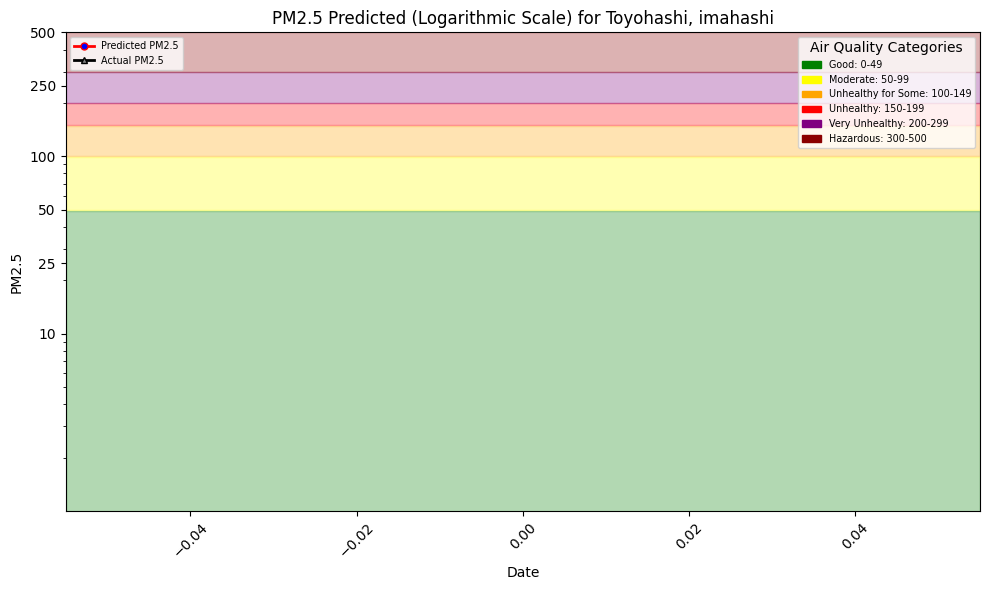

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_forecast_imahashi.png: 0.000%|          | 0/4…

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_hindcast_1day_imahashi.png: 0.000%|          …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286329/settings/fb/path/Resources/airquality_v_agrade
2025-11-15 16:11:08,061 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 16:11:08,064 INFO: Initializing external client
2025-11-15 16:11:08,064 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 16:11:08,612 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 16:11:09,410 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286329
2025-11-15 16:11:13,821 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/538100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/549281 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/514472 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114640 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112266 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108903 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26639 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26895 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27075 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.13s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 


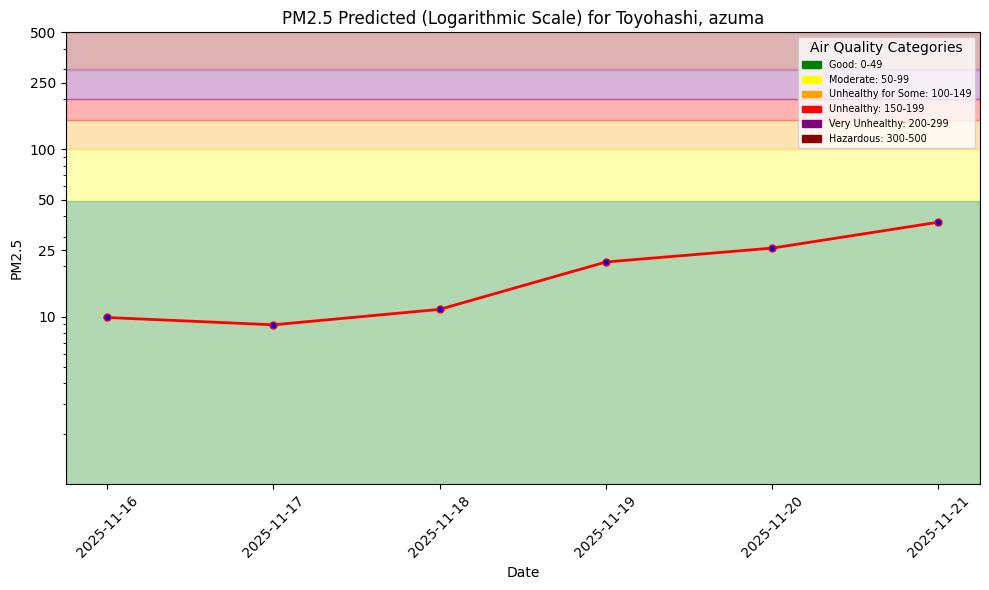

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286329/fs/1273951/fg/1718647


Uploading Dataframe: 100.00% |██████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_azuma_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286329/jobs/named/aq_predictions_v_agrade_azuma_1_offline_fg_materialization/executions
2025-11-15 16:11:46,497 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 16:12:07,211 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 16:13:33,418 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 16:13:33,562 INFO: Waiting for log aggregation to finish.
2025-11-15 16:13:44,034 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.88s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.97s) 
0


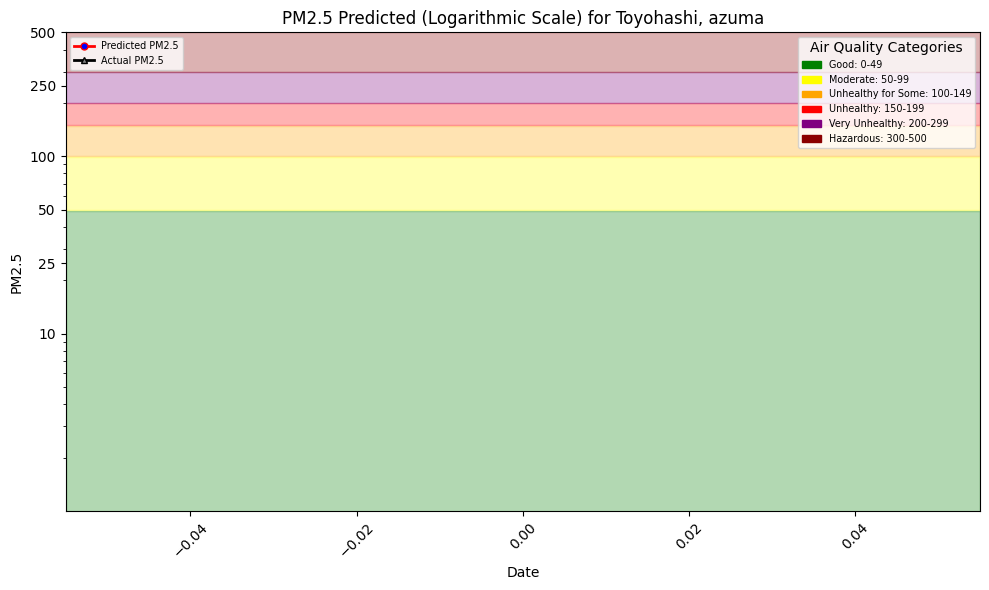

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_forecast_azuma.png: 0.000%|          | 0/4453…

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_hindcast_1day_azuma.png: 0.000%|          | 0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286329/settings/fb/path/Resources/airquality_v_agrade
2025-11-15 16:13:51,777 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 16:13:51,779 INFO: Initializing external client
2025-11-15 16:13:51,779 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 16:13:52,313 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 16:13:53,058 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286329
2025-11-15 16:13:57,277 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/523847 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/538100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/549281 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/514472 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114590 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114640 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112266 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108903 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27006 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26639 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26895 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27075 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.56s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


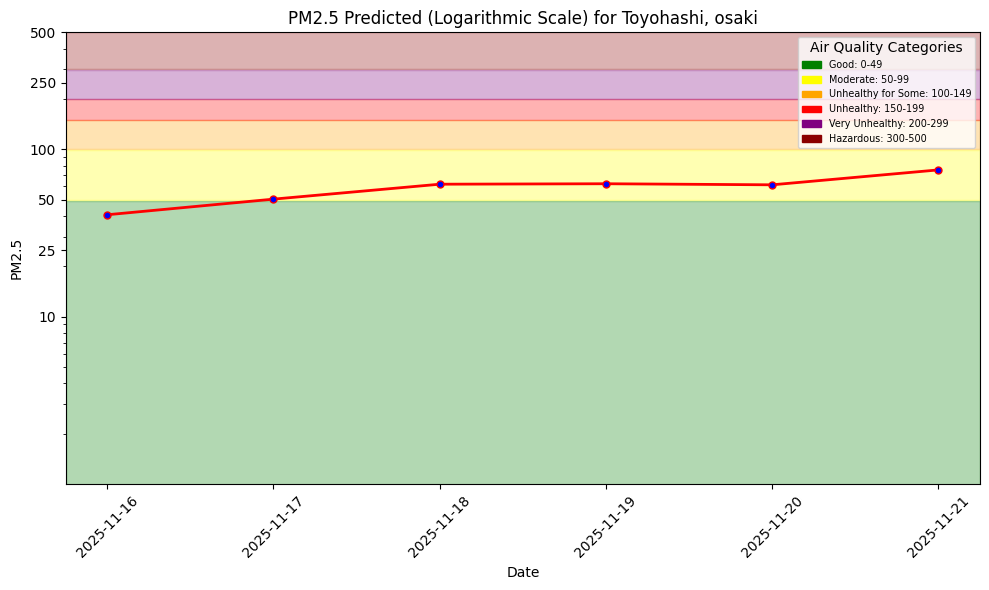

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286329/fs/1273951/fg/1718648


Uploading Dataframe: 100.00% |██████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_osaki_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286329/jobs/named/aq_predictions_v_agrade_osaki_1_offline_fg_materialization/executions
2025-11-15 16:14:30,087 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 16:15:06,910 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 16:16:56,861 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 16:16:57,005 INFO: Waiting for log aggregation to finish.
2025-11-15 16:17:07,473 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.99s) 
0


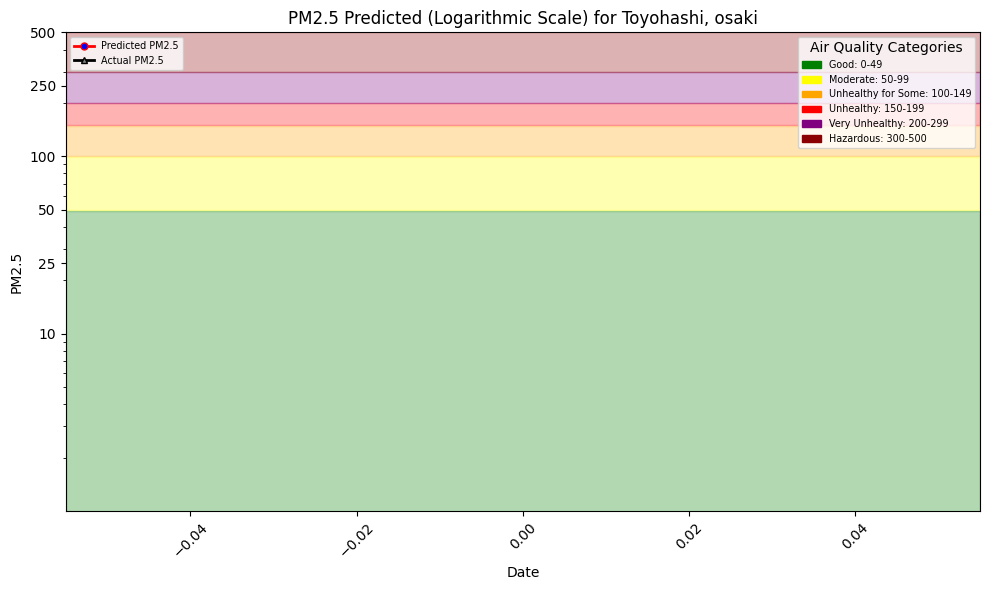

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_forecast_osaki.png: 0.000%|          | 0/4173…

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_hindcast_1day_osaki.png: 0.000%|          | 0…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286329/settings/fb/path/Resources/airquality_v_agrade
2025-11-15 16:17:19,596 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 16:17:19,598 INFO: Initializing external client
2025-11-15 16:17:19,598 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 16:17:20,133 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 16:17:21,093 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286329
2025-11-15 16:17:26,077 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/523847 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/541657 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/538100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/549281 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/514472 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114590 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115290 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114640 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112266 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108903 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27006 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27032 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26639 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26895 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27075 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.63s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.62s) 


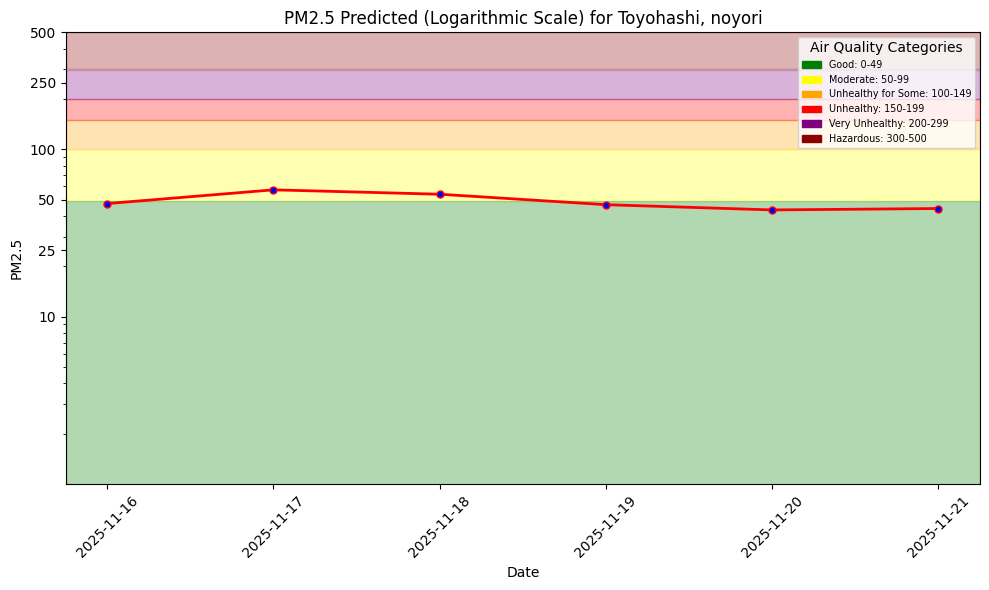

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286329/fs/1273951/fg/1719640


Uploading Dataframe: 100.00% |██████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_noyori_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286329/jobs/named/aq_predictions_v_agrade_noyori_1_offline_fg_materialization/executions
2025-11-15 16:17:59,461 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 16:18:02,623 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 16:19:36,960 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 16:19:37,153 INFO: Waiting for log aggregation to finish.
2025-11-15 16:19:45,815 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.89s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
0


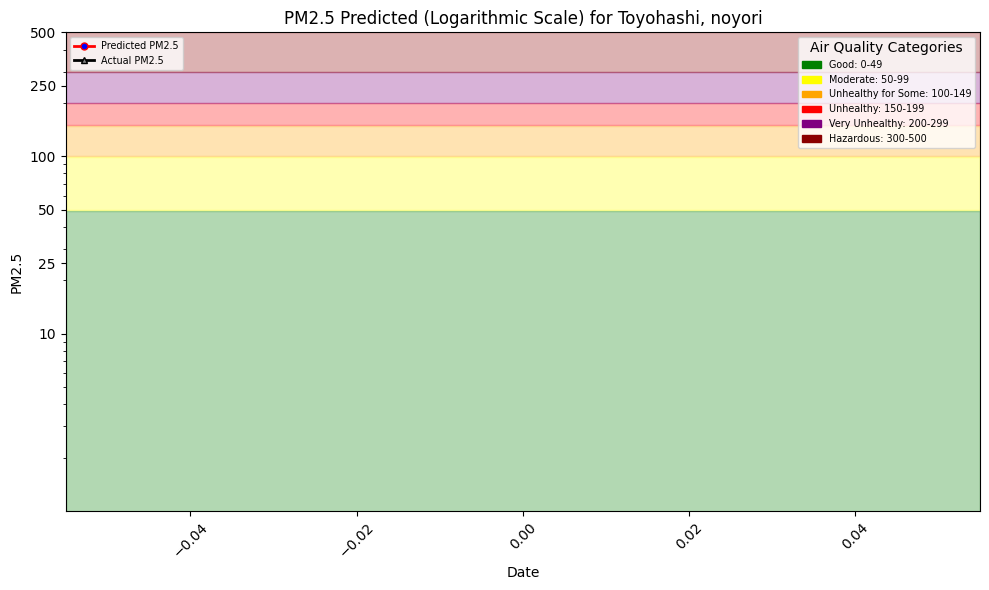

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_forecast_noyori.png: 0.000%|          | 0/422…

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_hindcast_1day_noyori.png: 0.000%|          | …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286329/settings/fb/path/Resources/airquality_v_agrade
2025-11-15 16:19:55,231 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-15 16:19:55,234 INFO: Initializing external client
2025-11-15 16:19:55,234 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-15 16:19:55,796 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-15 16:19:56,568 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286329
2025-11-15 16:20:01,707 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/523847 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/552572 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/541657 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/538100 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/549281 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/514472 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114590 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111143 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/115290 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/114640 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/112266 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/108903 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27006 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26596 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27032 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26639 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26895 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/27075 elapsed<00:00 remaining<?

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (5.60s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 


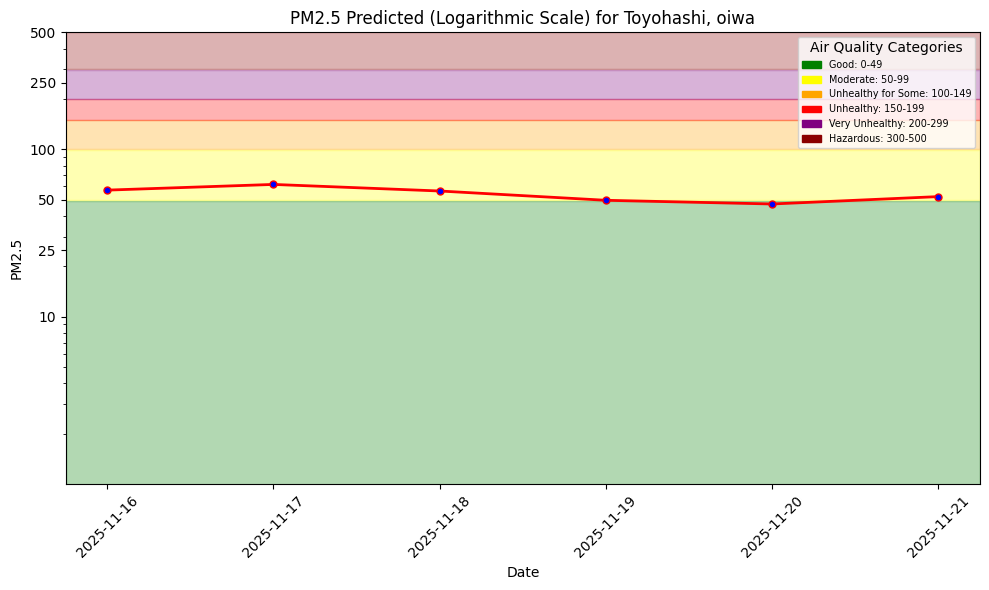

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1286329/fs/1273951/fg/1703568


Uploading Dataframe: 100.00% |██████████████████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_v_agrade_oiwa_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286329/jobs/named/aq_predictions_v_agrade_oiwa_1_offline_fg_materialization/executions
2025-11-15 16:20:42,666 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 16:21:03,686 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 16:22:42,453 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-15 16:22:47,714 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 16:22:47,866 INFO: Waiting for log aggregation to finish.
2025-11-15 16:22:56,391 INFO: Execution finished successfully.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.83s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Ser

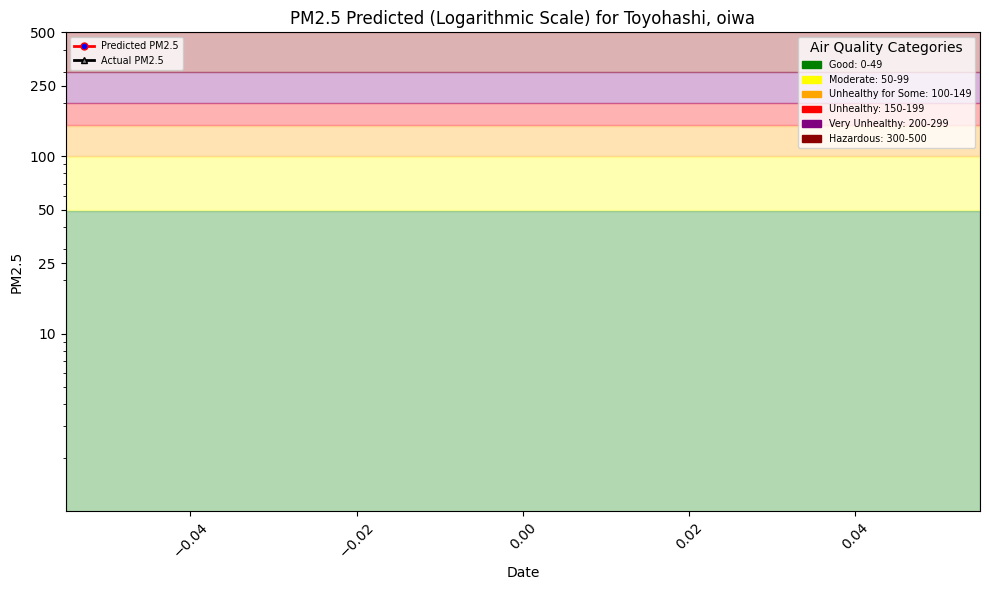

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_forecast_oiwa.png: 0.000%|          | 0/41582…

Uploading /home/olive/dev/lab1A/docs/air-quality/assets/img/pm25_hindcast_1day_oiwa.png: 0.000%|          | 0/…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286329/settings/fb/path/Resources/airquality_v_agrade


In [126]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)

locations = {
                "imahashi":
                    {
                        "url":"https://api.waqi.info/feed/@2543",
                        "lat":"34.766389", 
                        "long":"137.393889"
                    },
                "azuma": 
                    {
                        "url":"https://api.waqi.info/feed/@2374",
                        "lat":"34.7632176",
                        "long":"137.4145777"
                    },
                "osaki": 
                    {
                        "url":"https://api.waqi.info/feed/@2372",
                        "lat":"34.712222",
                        "long":"137.346944"
                    },
                "noyori": 
                    {
                        "url":"https://api.waqi.info/feed/@6600",
                        "lat":"34.698889", 
                        "long":"137.39"
                    },
                "oiwa": 
                    {
                        "url":"https://api.waqi.info/feed/@2373",
                        "lat":"34.721944", 
                        "long":"137.450833"
                    }
            }

def full_pipeline(stations):

    for station, metadata in stations.items():

        street = station
        url = metadata["url"]
    
        project, fs, country, city, street = get_env(street)
    
        retrieved_xgboost_model,fv = get_model(project,street)    
    
        batch_data, weather_fg = get_forecast_stuff(fs,street,today)
    
        batch_data, adj_tomorrow, first_init_roll = add_rolling(fs,street,batch_data)
    
        batch_data = predictions(adj_tomorrow,batch_data,retrieved_xgboost_model,country,city,street,url,first_init_roll)
    
        batch_data = add_info_data(batch_data,street,city,country)
    
        pred_file_path = create_forecast(street,city,batch_data)
    
        monitor_fg = create_monitor_fg(street,batch_data, fs)
    
        monitoring_df = create_monitor_df(monitor_fg)
    
        air_quality_fg, air_quality_df = create_aq_df(fs,street)
    
        hindcast_df = hindcast(air_quality_df, monitoring_df)
    
        hindcast_file_path = plot_hindcast(street,city,hindcast_df)
    
        upload_hops(project, today, city, street, pred_file_path, hindcast_file_path)

full_pipeline(locations)

---